# ConnectX Project


Name: Pablo Salar Carrera <BR>
UCID: ps2255 <BR>
Professor: Dr. Li <BR>
Course: DS 669 <BR>

First we have to make sure we install the required packages: torch, numpy, random, matplotlib, kaggle_environments, inspect, os, sys. <br>
The way to install these packages is by writing on the terminal: <br>
pip install (name of package) <br>
or by writing in a cell and running it: <br>
!pip install (name of package)

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
from kaggle_environments import make, evaluate, utils
import inspect
import os
import sys

Once we have installed all required packages and import the libraries, we can initiallize the environment for the ConnectX game.

In [2]:
env = make("connectx", debug=True)

In [3]:
config = env.configuration
config

{'episodeSteps': 1000,
 'actTimeout': 2,
 'runTimeout': 1200,
 'columns': 7,
 'rows': 6,
 'inarow': 4,
 'agentTimeout': 60,
 'timeout': 2}

In [4]:
columns = config.columns
rows = config.rows
inarow = config.inarow

We check for the default configuration of the game. And visualize how the board looks like: 

In [5]:
env = make("connectx", debug=True)
env.render(mode="ipython")

This is an example of how the game is played against a random agent.

In [ ]:
# Run a game with two random agents
env.run(["random", "random"])

# Render the game
env.render(mode="ipython")

As a first step, we define some basic rules/movements we want our agent to learn.

In [65]:
def check_four_in_a_row(board, player):
    """Check if the given player has made 4 in a row."""
    for row in range(6):  # Board has 6 rows
        for col in range(7):  # Board has 7 columns
            if board[row][col] == player:
                # Check all directions (horizontal, vertical, diagonal)
                for d_row, d_col in [(0, 1), (1, 0), (1, 1), (1, -1)]:
                    count = 0
                    for step in range(4):
                        r, c = row + d_row * step, col + d_col * step
                        if 0 <= r < 6 and 0 <= c < 7 and board[r][c] == player:
                            count += 1
                        else:
                            break
                    if count == 4:
                        return True
    return False

def check_three_in_a_row(board, player):
    """Check if the given player has made 3 in a row."""
    for row in range(6):  # Board has 6 rows
        for col in range(7):  # Board has 7 columns
            if board[row][col] == player:
                # Check all directions (horizontal, vertical, diagonal)
                for d_row, d_col in [(0, 1), (1, 0), (1, 1), (1, -1)]:
                    count = 0
                    for step in range(3):  # Checking for 3 in a row instead of 4
                        r, c = row + d_row * step, col + d_col * step
                        if 0 <= r < 6 and 0 <= c < 7 and board[r][c] == player:
                            count += 1
                        else:
                            break
                    if count == 3:
                        return True
    return False


def evaluate_state(board, agent, opponent):
    """
    Evaluate the state of the board for the agent.
    Focuses on moves that can lead to 4 in a row and avoids meaningless 3 in a row.
    """
    score = 0

    # Check for agent's potential 4 in a row
    if check_four_in_a_row(board, agent):
        return 1000  # High score for winning

    # Check for opponent's potential 4 in a row (defense)
    if check_four_in_a_row(board, opponent):
        return -1000  # High penalty for allowing opponent to win
    
    # Prioritize the center column
    center_col = 3
    center_score = 20  # Reward for taking center column
    center_count = sum(1 for row in range(6) if board[row][center_col] == agent)
    score += center_count * center_score


    # Evaluate potential 3 in a row with continuity to 4
    for row in range(6):
        for col in range(7):
            if board[row][col] == 0:  # Empty spot to consider a move
                # Simulate the agent's move
                temp_board = board.copy()
                temp_board[row][col] = agent
                if check_three_in_a_row(temp_board, agent):
                    # Ensure it can lead to 4 in a row
                    for d_row, d_col in [(0, 1), (1, 0), (1, 1), (1, -1)]:
                        r, c = row, col
                        potential = 0
                        for step in range(4):
                            r, c = row + d_row * step, col + d_col * step
                            if 0 <= r < 6 and 0 <= c < 7:
                                if temp_board[r][c] == agent:
                                    potential += 1
                                elif temp_board[r][c] != 0:
                                    break  # Blocked by opponent
                            else:
                                break
                        if potential == 3 and 0 <= r < 6 and 0 <= c < 7 and temp_board[r][c] == 0:
                            score += 50  # Add a reward for potential 4 in a row
                            break

    # Default penalty for moves that don't contribute meaningfully
    return score - 1



def get_reward(board, agent, opponent):
    """Enhanced reward function based on the board state."""
    # Check if agent won
    if check_four_in_a_row(board, agent):
        return 100  # High reward for winning
    # Check if opponent won
    if check_four_in_a_row(board, opponent):
        return -200  # High penalty for allowing opponent to win
    block_move = check_three_in_a_row(board, opponent)
    if block_move:
        return 40  # Reward for blocking opponent's progression
    # Penalize letting opponent get close to winning
    if check_three_in_a_row(board, agent):
        return 5  # Small reward for making progress towards winning
    return -1  # Default penalty for each move


Then, we define our DQN model and our DQN Agent that will learn how to play the game.

In [66]:
# DQN Model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 6 * 7, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = x.view(-1, 1, 6, 7)  # Reshape input
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Experience Replay with Prioritization
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.pos = 0

    def push(self, experience, priority=1.0):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.pos] = (experience, priority)
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        priorities = np.array([experience[1] for experience in self.buffer])
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)

        batch = [self.buffer[idx][0] for idx in indices]
        weights = (len(self.buffer) * probabilities[indices]) ** (-beta)
        weights /= weights.max()

        return batch, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.buffer[idx] = (self.buffer[idx][0], priority)

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(10000)  # Use prioritized replay buffer
        self.gamma = 0.99
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.update_target_model()
        self.update_counter = 0

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state):
    
        valid_actions = [c for c in range(self.action_size) if state[c] == 0]
        if not valid_actions:
            return None  # No valid moves

        # Epsilon-greedy strategy
        if np.random.rand() <= self.epsilon:
            return random.choice(valid_actions)

        # Evaluate potential moves
        state_board = np.array(state).reshape(6, 7)
        
        # Check for immediate win
        for action in valid_actions:
            temp_board = state_board.copy()
            for row in reversed(range(6)):
                if temp_board[row][action] == 0:
                    temp_board[row][action] = 1  # Simulate agent's move
                    break
                if check_four_in_a_row(temp_board, 1):
                    return action  # Take the winning move
                    

        # Check for immediate block (defense)
        for action in valid_actions:
            temp_board = state_board.copy()
            for row in reversed(range(6)):
                if temp_board[row][action] == 0:
                    temp_board[row][action] = -1  # Simulate opponent's move
                    break
                if check_four_in_a_row(temp_board, -1):
                    return action  # Block the opponent's win
            
        # Prioritize the center column early in the game if it's empty
        if state[3] == 0 and sum(state) == 0:  # Check if it's the first move and center is unoccupied
            return 3

        
        best_action = None
        best_score = -float('inf')

        for action in valid_actions:
            # Simulate the move
            temp_board = state_board.copy()
            for row in reversed(range(6)):
                if temp_board[row][action] == 0:
                    temp_board[row][action] = 1  # Simulate agent's move
                    break
                    
                
            # Evaluate the resulting state
            score = evaluate_state(temp_board, agent=1, opponent=-1)
            if score > best_score:
                best_score = score
                best_action = action

        return best_action


    def remember(self, state, action, reward, next_state, done):
        # Prioritize experiences with higher TD-error
        td_error = abs(reward + (1 - done) * self.gamma * np.max(self.target_model(torch.FloatTensor(next_state).unsqueeze(0)).detach().numpy()) - np.max(self.model(torch.FloatTensor(state).unsqueeze(0)).detach().numpy()))
        self.memory.push((state, action, reward, next_state, done), priority=td_error)

    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return

        # Sample a batch with prioritized experience replay
        batch, indices, weights = self.memory.sample(self.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.model(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_model(next_states).max(1)[0].detach()
        targets = rewards + (1 - dones) * self.gamma * next_q_values

        # Convert weights to tensor (ensure they are on the same device as the model)
        weights = torch.FloatTensor(weights).to(states.device)

        # Weighted loss for prioritized replay
        loss = (weights * (q_values.squeeze() - targets) ** 2).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
        # Update priorities for sampled experiences
        new_priorities = (q_values.squeeze() - targets).abs().cpu().detach().numpy()
        self.memory.update_priorities(indices, new_priorities)

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



Episode 50/1000, Total Reward: 159
Episode 100/1000, Total Reward: -168
Episode 150/1000, Total Reward: -202
Episode 200/1000, Total Reward: 158
Episode 250/1000, Total Reward: 273
Episode 300/1000, Total Reward: 114
Episode 350/1000, Total Reward: 319
Episode 400/1000, Total Reward: 717
Episode 450/1000, Total Reward: 637
Episode 500/1000, Total Reward: -169
Episode 550/1000, Total Reward: 515
Episode 600/1000, Total Reward: 74
Episode 650/1000, Total Reward: 276
Episode 700/1000, Total Reward: 719
Episode 750/1000, Total Reward: 677
Episode 800/1000, Total Reward: 230
Episode 850/1000, Total Reward: 279
Episode 900/1000, Total Reward: 596
Episode 950/1000, Total Reward: 597
Episode 1000/1000, Total Reward: 319


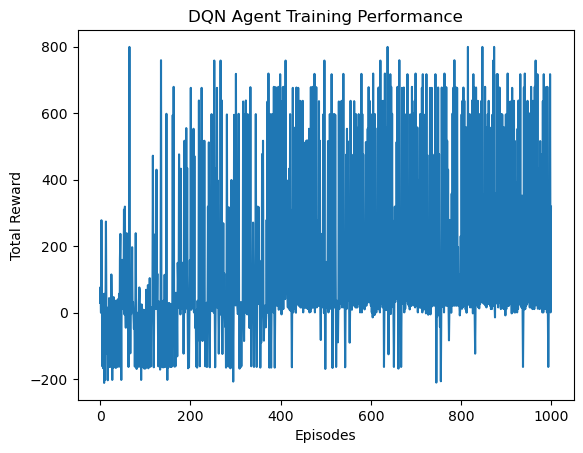

In [67]:

# Environment Setup
env = make("connectx", debug=True)

state_size = 42  # Flat board size
action_size = 7  # Number of columns
agent = DQNAgent(state_size, action_size)

# Training Loop
episodes = 1000
scores = []

for e in range(episodes):
    
    # Alternate roles: First player in odd episodes, second player in even episodes
    if e % 2 == 0:  # Play as first player
        trainer = env.train([None, "negamax"])
        agent_player = 1
        opponent_player = -1
    else:  # Play as second player
        trainer = env.train(["negamax", None])
        agent_player = -1
        opponent_player = 1
        
    observation = trainer.reset()
    state = observation['board']  # Initial board state
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        next_observation, reward, done, info = trainer.step(action)
        next_state = next_observation['board']
        
        next_state_2D = np.array(next_state).reshape(6, 7)

        # Proceed with reward function if next_state is a 2D list
  
        reward = get_reward(next_state_2D, agent_player, opponent_player)
        
            
        next_state_flat = next_state_2D.flatten()
        
        agent.remember(state, action, reward, next_state_flat, done)
        state = next_state_flat
        total_reward += reward

    agent.replay()
    agent.decay_epsilon()

    # Update target model every 10 episodes
    agent.update_counter += 1
    if agent.update_counter % 10 == 0:
        agent.update_target_model()

    scores.append(total_reward)
    if (e + 1) % 50 == 0:
        print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward}")

# Plot Training Performance
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("DQN Agent Training Performance")
plt.show()



We define our trained agent to later play against it and evaluate its performance against the random and negamax agents, which are the default agents for the ConnectX environment.

In [68]:
def agent_function(observation, configuration):
    state = np.array(observation['board']).flatten()
    action = agent.act(state)
    return action

In [180]:
env.reset()
env.play([None, agent_function], width=500, height=450)


In [72]:
env.reset()
env.play([agent_function, None], width=500, height=450)


In [61]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

Evaluate when agent moving first:

In [74]:
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [agent_function, "random"], num_episodes=10, debug=True)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [agent_function, "negamax"], num_episodes=10)))

My Agent vs Random Agent: 0.8
My Agent vs Negamax Agent: -0.8


Evaluate when agent starting second:

In [75]:
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", ["random", agent_function], num_episodes=10, debug=True)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", ["negamax", agent_function], num_episodes=10)))

My Agent vs Random Agent: -1.0
My Agent vs Negamax Agent: -0.4


Since our agent did not learn well enough to play the game, we implement another rule for the agent that might be useful to learn faster how the game works. Besides, we increase a bit the learning rate from 0.001 to 0.005. Moreover, we increase the training from 1000 episodes to 1500 episodes. 

In [137]:
def check_two_plus_one_in_a_row(board, player):
    """
    Checks if there is a two-in-a-row with one space in between
    that can lead to a four-in-a-row for the given player.
    """
    directions = [(0, 1), (1, 0), (1, 1), (1, -1)]  # Horizontal, vertical, diagonal
    rows, cols = board.shape

    for row in range(rows):
        for col in range(cols):
            if board[row][col] == player:
                for d_row, d_col in directions:
                    try:
                        # Check for two in a row with a space in between
                        r1, c1 = row + d_row, col + d_col
                        r2, c2 = r1 + d_row, c1 + d_col
                        r3, c3 = r2 + d_row, c2 + d_col

                        if (
                            0 <= r1 < rows
                            and 0 <= c1 < cols
                            and 0 <= r2 < rows
                            and 0 <= c2 < cols
                            and 0 <= r3 < rows
                            and 0 <= c3 < cols
                        ):
                            if (
                                board[r1][c1] == player
                                and board[r2][c2] == 0
                                and board[r3][c3] == player
                            ):
                                return True
                    except IndexError:
                        continue
    return False


In [136]:
def evaluate_state(board, agent, opponent):
    """
    Evaluate board state with focus on winning, blocking,
    and strategic setups like two-plus-one configurations.
    """
    score = 0

    # Winning move for the agent
    if check_four_in_a_row(board, agent):
        return 1000

    # Block opponent's winning move
    if check_four_in_a_row(board, opponent):
        return -1000

    # Reward 3-in-a-row setups that can lead to 4-in-a-row
    if check_three_in_a_row(board, agent):
        score += 100

    # Block opponent's 3-in-a-row setups
    if check_three_in_a_row(board, opponent):
        score += 50

    # Reward two-plus-one configuration for the agent
    if check_two_plus_one_in_a_row(board, agent):
        score += 75

    # Block opponent's two-plus-one configuration
    if check_two_plus_one_in_a_row(board, opponent):
        score += 50

    # Encourage early center column usage
    if np.sum(board[:, 3]) == 0:  # Empty center column
        score += 20

    return score


In [135]:
def get_reward(board, agent, opponent):
    """Reward function with focus on winning, blocking, and strategic moves."""
    # Winning move
    if check_four_in_a_row(board, agent):
        return 100  # High reward for winning

    # Losing move
    if check_four_in_a_row(board, opponent):
        return -200  # High penalty for losing

    # Block opponent's winning move
    if check_three_in_a_row(board, opponent):
        return 50  # Reward for blocking the opponent

    # Reward two-plus-one configuration
    if check_two_plus_one_in_a_row(board, agent):
        return 30  # Reward for taking advantage of the configuration

    # Block opponent's two-plus-one configuration
    if check_two_plus_one_in_a_row(board, opponent):
        return 40  # Reward for blocking the opponent

    # Penalize letting opponent get close to winning
    if check_three_in_a_row(board, agent):
        return 20  # Small reward for making progress towards winning
    
    # Encourage playing the center column early in the game
    if np.sum(board[:, 3]) == 0:  # If center column is empty
        return 20  # Reward for prioritizing the center column


    return -1  # Default penalty for each move


In [152]:
# DQN Model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 6 * 7, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = x.view(-1, 1, 6, 7)  # Reshape input
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Experience Replay with Prioritization
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.pos = 0

    def push(self, experience, priority=1.0):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.pos] = (experience, priority)
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        priorities = np.array([experience[1] for experience in self.buffer])
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)

        batch = [self.buffer[idx][0] for idx in indices]
        weights = (len(self.buffer) * probabilities[indices]) ** (-beta)
        weights /= weights.max()

        return batch, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.buffer[idx] = (self.buffer[idx][0], priority)

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(10000)  # Use prioritized replay buffer
        self.gamma = 0.99
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.005)
        self.update_target_model()
        self.update_counter = 0

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state):
        

        valid_actions = [c for c in range(self.action_size) if state[c] == 0]
        if not valid_actions:
            return None  # No valid moves

        state_board = np.array(state).reshape(6, 7)
        agent_player = 1  # Assuming the agent plays with '1'
        opponent_player = -1  # Assuming the opponent plays with '-1'

        # Check for winning move
        for action in valid_actions:
            temp_board = state_board.copy()
            for row in reversed(range(6)):
                if temp_board[row][action] == 0:
                    temp_board[row][action] = agent_player
                    break
            if check_four_in_a_row(temp_board, player=agent_player):
                return action

        # Check for blocking opponent's winning move
        for action in valid_actions:
            temp_board = state_board.copy()
            for row in reversed(range(6)):
                if temp_board[row][action] == 0:
                    temp_board[row][action] = opponent_player
                    break
            if check_four_in_a_row(temp_board, player=opponent_player):
                return action

        # Check for moves to set up three in a row leading to a potential win
        for action in valid_actions:
            temp_board = state_board.copy()
            for row in reversed(range(6)):
                if temp_board[row][action] == 0:
                    temp_board[row][action] = agent_player
                    break
            if check_three_in_a_row(temp_board, player=agent_player):
                return action

        # Default action: Random or prioritized based on game strategy
        if self.epsilon > np.random.rand():  # Exploration
            return random.choice(valid_actions)

        # Prioritize the center column if it's still early in the game
        if state[3] == 0 and len([x for x in state if x != 0]) < 3:
            return 3  # Center column index

        # Otherwise, evaluate actions based on the model
        best_action = None
        best_score = -float('inf')
        for action in valid_actions:
            temp_board = state_board.copy()
            for row in reversed(range(6)):
                if temp_board[row][action] == 0:
                    temp_board[row][action] = agent_player
                    break
            score = evaluate_state(temp_board, agent_player, opponent_player)
            if score > best_score:
                best_score = score
                best_action = action

        return best_action


    def remember(self, state, action, reward, next_state, done):
        # Prioritize experiences with higher TD-error
        td_error = abs(reward + (1 - done) * self.gamma * np.max(self.target_model(torch.FloatTensor(next_state).unsqueeze(0)).detach().numpy()) - np.max(self.model(torch.FloatTensor(state).unsqueeze(0)).detach().numpy()))
        self.memory.push((state, action, reward, next_state, done), priority=td_error)

    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return

        # Sample a batch with prioritized experience replay
        batch, indices, weights = self.memory.sample(self.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.model(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_model(next_states).max(1)[0].detach()
        targets = rewards + (1 - dones) * self.gamma * next_q_values

        # Convert weights to tensor (ensure they are on the same device as the model)
        weights = torch.FloatTensor(weights).to(states.device)

        # Weighted loss for prioritized replay
        loss = (weights * (q_values.squeeze() - targets) ** 2).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
        # Update priorities for sampled experiences
        new_priorities = (q_values.squeeze() - targets).abs().cpu().detach().numpy()
        self.memory.update_priorities(indices, new_priorities)

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



In [153]:

# Environment Setup
env = make("connectx", debug=True)

state_size = 42  # Flat board size
action_size = 7  # Number of columns

def train_agent():
    agent3 = DQNAgent(state_size, action_size)

    # Training Loop
    episodes = 1500
    scores = []

    for e in range(episodes):

        # Alternate roles: First player in odd episodes, second player in even episodes
        if e % 2 == 0:  # Play as first player
            trainer = env.train([None, "negamax"])
            agent_player = 1
            opponent_player = -1
        else:  # Play as second player
            trainer = env.train(["negamax", None])
            agent_player = -1
            opponent_player = 1

        observation = trainer.reset()
        state = observation['board']  # Initial board state
        done = False
        total_reward = 0

        while not done:
            action = agent3.act(state)
            next_observation, reward, done, info = trainer.step(action)
            next_state = next_observation['board']

            next_state_2D = np.array(next_state).reshape(6, 7)

            # Proceed with reward function if next_state is a 2D list

            reward = get_reward(next_state_2D, agent_player, opponent_player)


            next_state_flat = next_state_2D.flatten()

            agent3.remember(state, action, reward, next_state_flat, done)
            state = next_state_flat
            total_reward += reward

        agent3.replay()
        agent3.decay_epsilon()

        # Update target model every 10 episodes
        agent3.update_counter += 1
        if agent3.update_counter % 10 == 0:
            agent3.update_target_model()

        scores.append(total_reward)
        if (e + 1) % 100 == 0:
            print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward}")

    # Plot Training Performance
    plt.plot(scores)
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("DQN Agent Training Performance")
    plt.show()
    
    
    return agent3


Episode 100/1500, Total Reward: 346
Episode 200/1500, Total Reward: 345
Episode 300/1500, Total Reward: 387
Episode 400/1500, Total Reward: 275
Episode 500/1500, Total Reward: 344
Episode 600/1500, Total Reward: 345
Episode 700/1500, Total Reward: 396
Episode 800/1500, Total Reward: 343
Episode 900/1500, Total Reward: 540
Episode 1000/1500, Total Reward: 185
Episode 1100/1500, Total Reward: 497
Episode 1200/1500, Total Reward: 241
Episode 1300/1500, Total Reward: 746
Episode 1400/1500, Total Reward: 145
Episode 1500/1500, Total Reward: 496


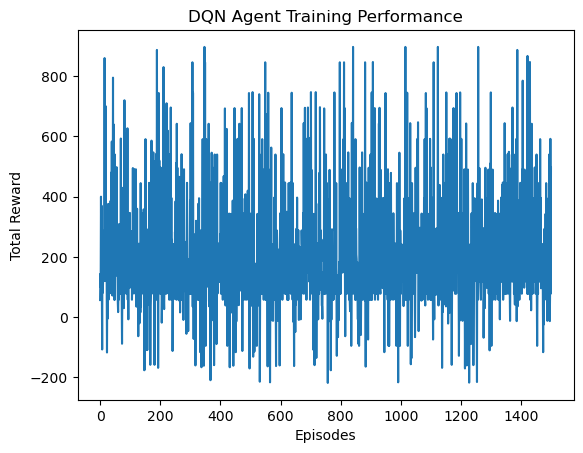

In [154]:
train_agent()

In [148]:
env.reset()
observation['board']

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

In [171]:
def agent_function3(observation, configuration):
    state = np.array(observation['board'])
    action = agent3.act(state)
    return action

In [165]:
agent3

In [155]:
env.reset()
env.play([None, agent3], width=500, height=450)

In [172]:
env.reset()
env.play([None, agent_function3], width=500, height=450)


In [173]:
env.reset()
env.play([agent_function3, None], width=500, height=450)


In [179]:
# Create a ConnectX environment
env = make("connectx", debug=True)

# Run a single episode with your agent playing against itself
env.run(['negamax', agent_function3])

# Visualize the game (optional)
env.render(mode="ipython")

# Check the result
if env.state[0].status == "DONE" and env.state[1].status == "DONE":
    print("Validation Episode passed!")
else:
    print("Validation Episode failed.")


Validation Episode passed!


In [159]:
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [agent_function3, "random"], num_episodes=10, debug=True)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [agent_function3, "negamax"], num_episodes=10)))

My Agent vs Random Agent: 1.0
My Agent vs Negamax Agent: -1.0


In [160]:
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", ["random", agent_function3], num_episodes=10, debug=True)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", ["negamax", agent_function3], num_episodes=10)))

My Agent vs Random Agent: -1.0
My Agent vs Negamax Agent: -0.3


## Conclusions
After training the agent with different number of hidden layers and hidden layer sizes. As we increased the number the training was slower, but the agent learned a little bit better. However, the improvement was not good enough in comparison with the time it took to process the deep network. 